# library

In [1]:
import pandas as pd
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import os
import FinanceDataReader as fdr

import datetime as dt

import numpy as np

from tqdm import tqdm #진행바
from tqdm.notebook import tqdm

#시각화 라이브러리
import matplotlib as mpl
import matplotlib.pyplot as plt
print("matplotlib version: {}". format(mpl.__version__))

import seaborn as sns
print("seaborn version: {}". format(sns.__version__))


#한글설정
import matplotlib.font_manager as fm

font_dirs = ['/usr/share/fonts/truetype/nanum', ]
font_files = fm.findSystemFonts(fontpaths=font_dirs)

for font_file in font_files:
    fm.fontManager.addfont(font_file)
    
# 한글 출력을 위해서 폰트 옵션을 설정합니다.
# "axes.unicode_minus" : 마이너스가 깨질 것을 방지

sns.set(font="NanumBarunGothic", 
        rc={"axes.unicode_minus":False},
        style='darkgrid')


import warnings
warnings.filterwarnings('ignore')

# GPU
import tensorflow as tf

#https://www.tensorflow.org/guide/gpu#allowing_gpu_memory_growth
#프로세스의 요구량만큼 메모리 사용 설정
gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)
if gpus:
    try:
        for i in range(len(gpus)):
            tf.config.experimental.set_memory_growth(gpus[i], True)
    except RuntimeError as e:
        # 프로그램 시작시에 메모리 증가가 설정되어야만 합니다
        print(e)
        
#지정해서 쓰고 싶으면 model 쓸 때는 with 구문 안에 넣기

matplotlib version: 3.4.2
seaborn version: 0.11.1
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


# data load 및 classification 전처리

In [2]:
df = pd.read_csv('stock_2018_10days.csv')
df['Next_Change'] = np.where(df['Next_Change']>0.05, 1, 0)

## 머신러닝 K-fold 교차 검증(cross validation)
데이터를 5-fold 교차검증으로 8개 모델을 학습하고 예측하여 평가한다.

In [3]:
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
import time

results=[]

def classification(model_):
    
    # data load
    df_ = pd.read_csv('stock_2018_10days.csv')
    df_['Next_Change'] = np.where(df_['Next_Change']>0.05, 1, 0)
    
    # data split X, y
    X = df_.iloc[:,2:-1]
    y = df_.iloc[:,-1]
    i=0

    # Cross Validation
    sss = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=0) # 학습  : test = 4 : 1 random split
    for train_idx, test_idx in sss.split(X,y):
        x_train = df_.iloc[train_idx,2:-1]
        y_train = df_.iloc[train_idx,-1]
        x_test = df_.iloc[test_idx,2:-1]
        y_test = df_.iloc[test_idx,-1]
        
        # start_time = time.time() #-------------------------------------------
        _ = model_.fit(x_train, y_train)
        # training_time = time.time() - start_time #-------------------------------------------
        
        y_pred_train = model_.predict(x_train) 
        y_pred_test = model_.predict(x_test) # 예측
        accuracy_train = accuracy_score(y_train, y_pred_train) # 설명변수 x_train에 대한 반응변수 y_train 예측의 정확도. 이미 학습할 때 사용한 데이터이므로 답을 아는 상태라 소용이 없다고 생각하면 됨.
        accuracy_test = accuracy_score(y_test, y_pred_test) # 학습에 사용하지 않은 설명변수 x_train에 대한 반응변수 y_test 예측의 정확도. 이게 늘 말하는 그 정확도임.
        roc_auc = roc_auc_score(y_test, y_pred_test)
        results.append([i,f'{str(model)[:str(model).index("(")]}',accuracy_train,accuracy_test, roc_auc])#, training_time
        i+=1
        
        

In [4]:
%%time

# 1. Logistic regression    
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(max_iter=1000)
temp = classification(model)


# 2. Decision tree
from sklearn.tree import DecisionTreeClassifier
model = DecisionTreeClassifier()
temp = classification(model)


# 3. Support vector machine
from sklearn.svm import SVC
model = SVC()
temp = classification(model)


# 4. Gaussian naive bayes
from sklearn.naive_bayes import GaussianNB
model = GaussianNB()
temp = classification(model)


# 5. K nearest neighbor
from sklearn.neighbors import KNeighborsClassifier
model = KNeighborsClassifier()
temp = classification(model)


# 6. Random forest
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier()
temp = classification(model)


# 7. Gradient boosing
from sklearn.ensemble import GradientBoostingClassifier
model = GradientBoostingClassifier()
temp = classification(model)


# 8. Neural network
from sklearn.neural_network import MLPClassifier
model = MLPClassifier(max_iter=1000)
temp = classification(model)


results # append 이미 되고있었구나,,, 그래서 뒤에서 5개만 뽑아서 보는거였구나,,,
# # 형태: i번째 학습, 학습 모델, train 정확도, test 정확도(최종정확도) 학습에 걸린 시간

CPU times: user 4min 2s, sys: 2min 12s, total: 6min 15s
Wall time: 2min 23s


[[0, 'LogisticRegression', 0.917200591424347, 0.9173228346456693, 0.5],
 [1, 'LogisticRegression', 0.917200591424347, 0.9173228346456693, 0.5],
 [2, 'LogisticRegression', 0.917200591424347, 0.9173228346456693, 0.5],
 [3, 'LogisticRegression', 0.917200591424347, 0.9173228346456693, 0.5],
 [4, 'LogisticRegression', 0.917200591424347, 0.9173228346456693, 0.5],
 [0, 'DecisionTreeClassifier', 1.0, 0.8267716535433071, 0.504802779480891],
 [1, 'DecisionTreeClassifier', 1.0, 0.8622047244094488, 0.5349478847332924],
 [2, 'DecisionTreeClassifier', 1.0, 0.8562992125984252, 0.5317290006131208],
 [3, 'DecisionTreeClassifier', 1.0, 0.84251968503937, 0.5350500715307583],
 [4, 'DecisionTreeClassifier', 1.0, 0.8326771653543307, 0.49718986306969143],
 [0, 'SVC', 0.917200591424347, 0.9173228346456693, 0.5],
 [1, 'SVC', 0.917200591424347, 0.9173228346456693, 0.5],
 [2, 'SVC', 0.917200591424347, 0.9173228346456693, 0.5],
 [3, 'SVC', 0.917200591424347, 0.9173228346456693, 0.5],
 [4, 'SVC', 0.917200591424347

## 교차검증 결과 종합

In [5]:
df_results =pd.DataFrame(data=results, 
                columns= ['iter','method','accuracy_train','accuracy_test', 'roc_auc'])#,'training_time'
df_results

,iter,method,accuracy_train,accuracy_test,roc_auc
0,0,LogisticRegression,0.917201,0.917323,0.500000
1,1,LogisticRegression,0.917201,0.917323,0.500000
2,2,LogisticRegression,0.917201,0.917323,0.500000
3,3,LogisticRegression,0.917201,0.917323,0.500000
4,4,LogisticRegression,0.917201,0.917323,0.500000
5,0,DecisionTreeClassifier,1.000000,0.826772,0.504803
6,1,DecisionTreeClassifier,1.000000,0.862205,0.534948
7,2,DecisionTreeClassifier,1.000000,0.856299,0.531729
8,3,DecisionTreeClassifier,1.000000,0.842520,0.535050
9,4,DecisionTreeClassifier,1.000000,0.832677,0.497190


## 테스트 데이터셋 정확도 플랏

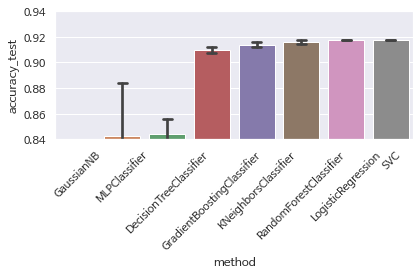

In [6]:
ax = sns.barplot(x="method", y="accuracy_test", data=df_results, capsize=.2, 
                 order=df_results.groupby('method').mean().sort_values('accuracy_test').index)
_ = ax.set(ylim=(0.84, 0.94))
_ = ax.set_xticklabels(ax.get_xticklabels(),rotation=45);## 테스트 데이터셋 정확도 플랏
_ = plt.tight_layout()

## 훈련-테스트 데이터셋 정확도 플랏

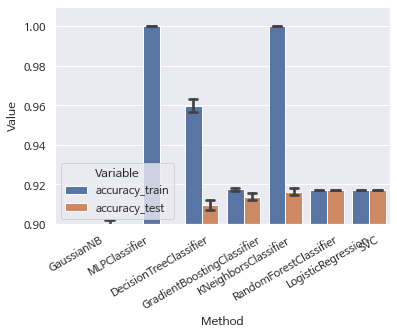

In [8]:
tidy = df_results[['method', 'accuracy_train', 'accuracy_test']].melt(id_vars='method').rename(columns=str.title)
ax = sns.barplot(x="Method", y="Value", hue='Variable', data=tidy, capsize=.2, 
                 order=df_results.groupby('method').mean().sort_values('accuracy_test').index)
ax.set(ylim=(0.90, 1.01))
ax.set_xticklabels(ax.get_xticklabels(),rotation=30);

## roc-auc plot

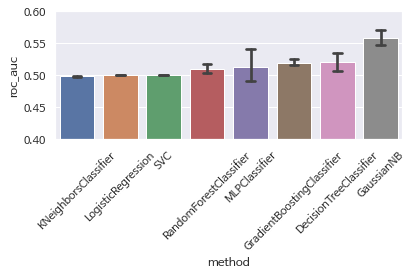

In [11]:
ax = sns.barplot(x="method", y="roc_auc", data=df_results, capsize=.2, 
                 order=df_results.groupby('method').mean().sort_values('roc_auc').index)
_ = ax.set(ylim=(0.4, 0.6))
_ = ax.set_xticklabels(ax.get_xticklabels(),rotation=45);## 테스트 데이터셋 정확도 플랏
_ = plt.tight_layout()